# Required libraries

In [1]:
!pip install numpy torch pillow torchvision opencv-python scikit-image matplotlib tqdm datasets diffusers transformers accelerate xformers kornia

INFO: pip is looking at multiple versions of xformers to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 90.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB

Some notes about libraries:
* xFormers is a library from Meta for memory efficient attention


In [2]:
import numpy as np
import torch
from PIL import Image
import kornia.color as kcolor
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
import random
import os
import cv2
import skimage.color as color
from skimage.color import lab2rgb
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
from datasets import load_dataset
from diffusers import (
    StableDiffusionPipeline,
    StableDiffusionControlNetImg2ImgPipeline,
    StableDiffusionControlNetPipeline,
    DPMSolverMultistepScheduler,
    UniPCMultistepScheduler,
    DDIMScheduler,
    DDPMPipeline
)
from diffusers.models import UNet2DConditionModel
from diffusers import ControlNetModel

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [3]:
device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cuda


In [4]:
!nvidia-smi

Mon Feb  3 15:09:21 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   45C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Imagenette dataset

Alternative dataset based on ImageNet with reduced resolution and/or the number of samples and labels.
Original ImageNet dataset is ~160GB.

In [5]:
dataset = torchvision.datasets.Imagenette(root="imagenette/", split='val', size='full', download=True)

100%|██████████| 1.56G/1.56G [01:59<00:00, 13.1MB/s]


Extracting imagenette/imagenette2.tgz to imagenette/


In [6]:
dataset.classes

[('tench', 'Tinca tinca'),
 ('English springer', 'English springer spaniel'),
 ('cassette player',),
 ('chain saw', 'chainsaw'),
 ('church', 'church building'),
 ('French horn', 'horn'),
 ('garbage truck', 'dustcart'),
 ('gas pump', 'gasoline pump', 'petrol pump', 'island dispenser'),
 ('golf ball',),
 ('parachute', 'chute')]

# Building the dataset for our task

We want to build a dataset that contains the images in the dataset grey scale along with the corrected colored image.
We want to use Lab color space separates luminance (L) from chrominance (a and b), which can be useful for tasks like colorization since the grayscale image corresponds directly to the L channel.

The dataset will output the L channel (input), ab channels (target), and the class label.

In [7]:
class GrayscaleLabDataset(Dataset):
    def __init__(self, root, transform=None):
        """
        Custom Dataset to load Imagenette and convert to CIE Lab color space.

        Parameters:
        - root (str): Path to the Imagenette dataset.
        - transform: Optional torchvision transformations.
        - device: Optional torch device.
        """
        self.dataset = torchvision.datasets.ImageFolder(root=root)
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]

        if self.transform:
            img = self.transform(img)

        img = img.permute(1, 2, 0).numpy() * 255  # Convert back to NumPy (H, W, C)
        img = img.astype(np.uint8)

        img_lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB).astype(np.float16)

        L = torch.tensor(img_lab[:, :, 0] / 255.0).unsqueeze(0)  # (1, H, W), L to [0, 1]
        ab = torch.tensor((img_lab[:, :, 1:] - 128) / 128).permute(2, 0, 1)  # (2, H, W), ab to [-1, 1]

        # if self.device: # This should be removed and move to device only the DataLoaders
        #     L = L.to(self.device)
        #     ab = ab.to(self.device)

        label = torch.tensor(label)#, device=self.device)

        return L, ab, label

In [8]:
image_size = 128 #128/224/256

In [9]:
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
])

imagenette_root = "imagenette/"

# Create GrayscaleLabDataset instance
full_dataset = GrayscaleLabDataset(
    root=imagenette_root,
    transform=transform
    #device=device
)

In [10]:
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

In [11]:
l_channel, ab_channels, label = val_dataset[0]

Check whether L-channel has range between [0,1] while ab channels have range between [-1,1]

In [12]:
print(l_channel.min(),l_channel.max())
print(ab_channels.min(),ab_channels.max())

tensor(0.0275, dtype=torch.float16) tensor(1., dtype=torch.float16)
tensor(-0.2344, dtype=torch.float16) tensor(0.3750, dtype=torch.float16)


Use dataloaders for loading batches of image in a efficient way

In [30]:
batch_size = 32

In [31]:
train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          drop_last=True)
val_loader = DataLoader(val_dataset,
                        batch_size=batch_size,
                        shuffle=True,
                        drop_last=True)

In [32]:
l_batch, ab_batch, label_batch = next(iter(train_loader))
lab_input = torch.cat([l_batch, ab_batch], dim=1)

# Print shapes
print("L channel shape:", l_batch.shape)  # Expected: (batch_size, 1, image_size, image_size)
print("AB channels shape:", ab_batch.shape)  # Expected:  (batch_size, 2, image_size, image_size)
print("Lab input shape:", lab_input.shape)  # Expected: (batch_size, 3, image_size, image_size)

L channel shape: torch.Size([32, 1, 128, 128])
AB channels shape: torch.Size([32, 2, 128, 128])
Lab input shape: torch.Size([32, 3, 128, 128])


**Important!** The range of the L-channel and ab channels are [0,1] and [-1,1] respectively (because they were normalized). In order to use `lab2rgb()` function they must be reconverted to [0,100] and [-128,127] range respectively.

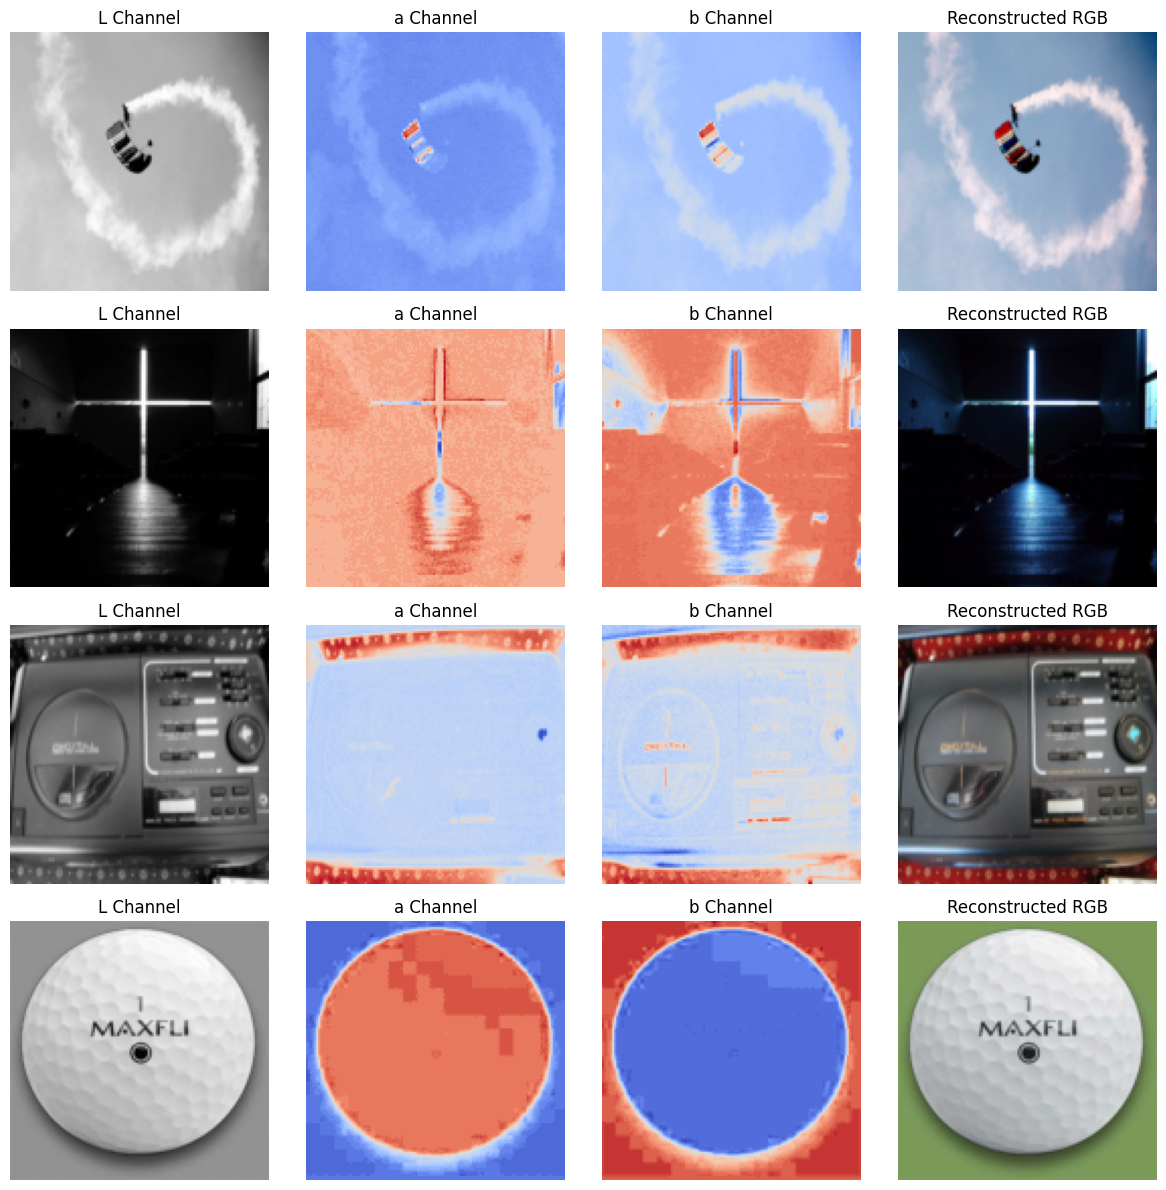

In [16]:
batch_size_graph = 4
def show_lab_images(dataloader):
    L_batch, ab_batch, _ = next(iter(dataloader))  # Get first batch
    L_batch, ab_batch = L_batch.cpu(), ab_batch.cpu()  # Move to CPU for visualization

    batch_size_graph = L_batch.shape[0]
    fig, axes = plt.subplots(batch_size_graph, 4, figsize=(12, batch_size_graph * 3))  # Now 4 columns

    for i in range(batch_size_graph):
        L = L_batch[i, 0, :, :].numpy()  # (H, W)
        a = ab_batch[i, 0, :, :].numpy()  # (H, W)
        b = ab_batch[i, 1, :, :].numpy()  # (H, W)

        # Rescale L from [0, 1] to [0, 100]
        L_rescaled = L * 100

        # Rescale a and b from [-1, 1] to [-128, 127]
        a_rescaled = a * 128
        b_rescaled = b * 128

        # Convert LAB to RGB
        lab_img = np.stack([L_rescaled, a_rescaled, b_rescaled], axis=-1)  # (H, W, 3)
        rgb_img = lab2rgb(lab_img)  # Convert to RGB

        # Plot L, a, b, and RGB image
        axes[i, 0].imshow(L, cmap="gray")
        axes[i, 0].set_title("L Channel")

        axes[i, 1].imshow(a, cmap="coolwarm")
        axes[i, 1].set_title("a Channel")

        axes[i, 2].imshow(b, cmap="coolwarm")
        axes[i, 2].set_title("b Channel")

        axes[i, 3].imshow(rgb_img)
        axes[i, 3].set_title("Reconstructed RGB")

        for ax in axes[i]:
            ax.axis("off")

    plt.tight_layout()
    plt.show()

show_lab_images(val_loader)

# ControlNet

[Paper](https://arxiv.org/pdf/2302.05543), provide a new condition by embedding new module layers into the existing network architecture.
![image.png](https://miro.medium.com/v2/resize:fit:640/format:webp/1*V-j6Yxr1GKvL_BMQnN-Www.png)

These modules are initialized by duplicating encoding layers from the pre-trained network and connected to the original model through “zero-convolutions” (a mechanism that initializes layers parameters to zero, this serves as a “safe” way to add new pathways to a pre-trained network). Note how the original network layers remain unchanged, maintaining the capabilities of the original diffusion model, safely adding new control capabilities.

In [17]:
controlnet = ControlNetModel.from_pretrained(
    "thibaud/controlnet-sd21-canny-diffusers",  # Use a ControlNet conditioned on Canny edges
    #thibaud/controlnet-sd21-color-diffusers # If i take this I do not know what image it expects, probably the concatenated one?
    torch_dtype=torch.float16
).to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/988 [00:00<?, ?B/s]

An error occurred while trying to fetch thibaud/controlnet-sd21-canny-diffusers: thibaud/controlnet-sd21-canny-diffusers does not appear to have a file named diffusion_pytorch_model.safetensors.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


diffusion_pytorch_model.bin:   0%|          | 0.00/729M [00:00<?, ?B/s]

In [ ]:
# controlnet.conv_in = nn.Conv2d(1, controlnet.config.block_out_channels[0], kernel_size=3, padding=1)
# controlnet.conv_in.weight = nn.Parameter(controlnet.conv_in.weight.type(torch.float16))
# controlnet.conv_in.bias = nn.Parameter(controlnet.conv_in.bias.type(torch.float16))

# Defining the model

Model card: https://huggingface.co/stabilityai/stable-diffusion-2-1\

It is a fine-tuned model from https://huggingface.co/stabilityai/stable-diffusion-2.

In [18]:
model_id = "stabilityai/stable-diffusion-2-1"

In [19]:
pipe = StableDiffusionControlNetImg2ImgPipeline.from_pretrained(
    model_id,
    controlnet=controlnet,
    torch_dtype=torch.float16
)
#pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_vae_slicing()
pipe.enable_xformers_memory_efficient_attention()
pipe = pipe.to(device)

model_index.json:   0%|          | 0.00/537 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/824 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/345 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/633 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/611 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/939 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [20]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

# Count parameters for each model component in the pipeline
total_params = 0
for name, component in pipe.components.items():
    if hasattr(component, "parameters"):
        num_params = count_parameters(component)
        print(f"{name}: {num_params:,} parameters")
        total_params += num_params

print(f"Total parameters in pipeline: {total_params:,}")

vae: 83,653,863 parameters
text_encoder: 340,387,840 parameters
unet: 865,910,724 parameters
controlnet: 364,228,240 parameters
Total parameters in pipeline: 1,654,180,667


In [ ]:
#pipe.unet.conv_in = nn.Conv2d(3, 320, kernel_size=3, padding=1).to(torch.float16).to(device)

In [ ]:
#pipe.unet.conv_out = nn.Conv2d(320, 2, kernel_size=3, padding=1).to(torch.float16).to(device)

In [ ]:
#pipe.controlnet.conv_out = nn.Conv2d(320, 2, kernel_size=3, padding=1).to(torch.float16).to(device) NO

Freeze the UNet parameters because we will train only the ones added with ControlNet.

In [21]:
for param in pipe.unet.parameters():
    param.requires_grad = False

In [22]:
for param in pipe.controlnet.parameters():
    param.requires_grad = True

In [ ]:
pipe.vae.requires_grad_(False)
pipe.text_encoder.requires_grad_(False);

NOTE:

ControlNet adds additional conditioning to the model, which involves extra processing steps rather than altering the network architecture of U-Net directly like I was doing before with the convolution layer adjustments.

# Training the model

In [33]:
num_epochs = 20
optimizer = torch.optim.Adam(pipe.controlnet.parameters(),lr=1e-4)
# optimizer = torch.optim.AdamW(pipe.controlnet.parameters(),lr=1e-4)
pipe = pipe.to(device)

In [34]:
def lab_to_canny(lab_tensor, low_threshold=100, high_threshold=200):
    """
    Convert LAB image batch (torch tensor) to 3-channel Canny edges.

    Args:
        lab_tensor (torch.Tensor): Shape (B, 3, H, W) -> (B, L, A, B).
        low_threshold (int): Lower bound for Canny edges.
        high_threshold (int): Upper bound for Canny edges.

    Returns:
        torch.Tensor: Canny edge maps (B, 3, H, W).
    """
    # Extract the L channel (grayscale)
    l_channel = lab_tensor[:, 0, :, :].cpu().numpy()  # Convert to NumPy (B, H, W)

    edge_maps = []

    for i in range(l_channel.shape[0]):  # Process batch images individually
        l_image = (l_channel[i] * 255).astype(np.uint8)  # Rescale to [0, 100]

        # Apply Canny edge detection to the L-channel (grayscale image)
        edges = cv2.Canny(l_image, low_threshold, high_threshold)  # Apply Canny (H, W)

        # Convert to 3 channels (H, W) -> (H, W, 3)
        edges_3ch = np.stack([edges] * 3, axis=2)  # Shape: (H, W, 3)

        edge_maps.append(edges_3ch)

    # Convert edge maps to a torch tensor
    edge_tensor = torch.tensor(np.array(edge_maps), dtype=torch.float16) / 255.0  # (B, H, W, 3)

    # Reorder the tensor to (B, 3, H, W) format (channels first)
    edge_tensor = edge_tensor.permute(0, 3, 1, 2)  # (B, 3, H, W)

    return edge_tensor.to(lab_tensor.device)

## Training Loop

In this training loop we aim to fine tune the stable diffusion model using ControlNet. As starting image the the SD model will receive a concatenation of the ground truth L-channel with the noisy ab-channels. The loss will be computed between the extracted denoised ab-channel and the clean ab-channels.

In [36]:
i=0
for epoch in range(num_epochs):
    epoch_losses = []  # Track losses for the epoch

    print(f"\nEpoch {epoch + 1}/{num_epochs} --------------------------")

    for batch_idx, batch in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1} Progress")):
        l_channel, ab_channels, _ = batch

        l_channel, ab_channels = l_channel.to(device), ab_channels.to(device)

        # # Rescale L-channel from [0, 1] to [0, 100] to use skimage functions as rgb2lab
        # l_channel_rescaled = l_channel * 100 # IF WE HAVE TO PLOT IMAGES MOVE THIS

        # # Rescale AB channels from [-1, 1] to [-128, 127] to use skimage functions as rgb2lab
        # ab_channels_rescaled = ab_channels * 128 # IF WE HAVE TO PLOT IMAGES MOVE THIS

        # Generate a random timestep
        timestep = torch.randint(0, pipe.scheduler.config.num_train_timesteps, (1,), dtype=torch.long).to(device)

        # Add noise to AB channels
        noise = torch.randn_like(ab_channels)  # Generate noise of the same shape as AB channels
        noisy_ab = pipe.scheduler.add_noise(ab_channels, noise, timestep)

        # Compute Canny edges
        l_channel_canny = l_channel.repeat(1, 3, 1, 1)
        canny_batch = lab_to_canny(l_channel_canny).to(device)

        lab_input_corrupted = torch.cat([l_channel, noisy_ab], dim=1)

        # Forward pass using Stable Diffusion
        outputs = pipe(
            prompt=[""] * batch_size,
            image=lab_input_corrupted,
            num_inference_steps=50,
            control_image=canny_batch
        ).images  # List of PIL images

        # TO PRINT WHAT'S PREDICTING FOR THAT STEP
        i+=1
        if i % 30 == 0:
            num_img = 5
            # Rescale L-channel from [0, 1] to [0, 100] to use skimage functions as rgb2lab
            l_channel_rescaled = l_channel * 100
            ab_channels_rescaled = ab_channels * 128
            # Convert ground truth LAB images to RGB for visualization
            ground_truth_lab = torch.cat([l_channel_rescaled[:num_img], ab_channels_rescaled[:num_img]], dim=1)  # (B, 3, H, W)
            ground_truth_rgb = kcolor.lab_to_rgb(ground_truth_lab)  # Convert to RGB

            fig, axes = plt.subplots(2, num_img, figsize=(num_img * 3, 6))

            for i in range(num_img):
                # Display generated image
                axes[0, i].imshow(outputs[i])
                axes[0, i].axis("off")
                axes[0, i].set_title("Generated")

                # Display ground truth image
                gt_img = transforms.ToPILImage()(ground_truth_rgb[i].cpu().clamp(0, 1))  # Convert to PIL
                axes[1, i].imshow(gt_img)
                axes[1, i].axis("off")
                axes[1, i].set_title("Ground Truth")

            plt.show()

        # What we obtain from the output of the pipe is a list of PIL images but we're working with tensors that must be differentiable, so we transform into tensors
        outputs_tensor = []
        for img in outputs:
            img_tensor = transforms.ToTensor()(img).to(device)
            img_tensor.requires_grad = True
            outputs_tensor.append(img_tensor)
        outputs_tensor = torch.stack(outputs_tensor)

        # Extract only AB channels
        outputs_lab = kcolor.rgb_to_lab(outputs_tensor)
        outputs_ab = outputs_lab[:, 1:, :, :]
        outputs_ab = (outputs_ab - 128) / 128  # Scale back to [-1, 1]

        # Compute MSE loss
        loss = F.mse_loss(outputs_ab.type(torch.float16), ab_channels)
        epoch_losses.append(loss.item())  # Store loss

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print loss for every 100th batch
        if batch_idx % 100 == 0:  # Print every 100 batches
            print(f"  Batch {batch_idx}/{len(train_loader)} - Loss: {loss.item():.6f}")

    # Epoch statistics
    avg_loss = np.mean(epoch_losses)
    min_loss = np.min(epoch_losses)
    max_loss = np.max(epoch_losses)
    loss_history.append(avg_loss)

    print(f"\nEpoch {epoch + 1} Summary:")
    print(f"  Average Loss: {avg_loss:.6f}")
    print(f"  Min Loss: {min_loss:.6f}")
    print(f"  Max Loss: {max_loss:.6f}")

# Plot loss curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), loss_history, marker="o", linestyle="-", color="blue")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.grid()
plt.show()


Epoch 1/20 --------------------------


Epoch 1 Progress:   0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1 Progress:   0%|          | 1/335 [00:14<1:21:49, 14.70s/it]

  Batch 0/335 - Loss: 1272.000000


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1 Progress:   1%|          | 2/335 [00:29<1:23:22, 15.02s/it]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1 Progress:   1%|          | 2/335 [00:42<1:58:34, 21.36s/it]


KeyboardInterrupt: 